# Simple word correlation for SERPs

By Pablo Rosales

Set project name for Google Drive directory

In [ ]:
PROJECT_NAME = 'coffee machine'

# Configurations for D4S

Set your D4S email in this variable.

In [ ]:
D4S_API_EMAIL = 'code@pablorosales.xyz'
LANGUAGE = 'English'
LOCATION = 'United States'

Run this cell and enter your D4S API password:

In [ ]:
from getpass import getpass
D4S_API_PASSWORD = getpass()

··········


# Google Drive mount

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Installs

In [ ]:
!apt -qq install chromium-chromedriver

The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 40 not upgraded.
Need to get 91.8 MB of archives.
After this operation, 315 MB of additional disk space will be used.
Selecting previously unselected package chromium-codecs-ffmpeg-extra.
(Reading database ... 148492 files and directories currently installed.)
Preparing to unpack .../chromium-codecs-ffmpeg-extra_92.0.4515.159-0ubuntu0.18.04.1_amd64.deb ...
Unpacking chromium-codecs-ffmpeg-extra (92.0.4515.159-0ubuntu0.18.04.1) ...
Selecting previously unselected package chromium-browser.
Preparing to unpack .../chromium-browser_92.0.4515.159-0ubuntu0.18.04.1_amd64.deb ...
Unpacking chromium-browser (92.0.

In [ ]:
!pip install pyppeteer --quiet

     |████████████████████████████████| 83 kB 1.7 MB/s 
     |████████████████████████████████| 103 kB 20.4 MB/s 
     |████████████████████████████████| 138 kB 27.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install nest-asyncio --quiet

# Imports

In [ ]:
import re
import os
import json
import nltk
import asyncio
import hashlib
import string
import scipy
import random
import multiprocessing
from collections import Counter
from pyppeteer import launch
from bs4 import BeautifulSoup
import nest_asyncio
from collections import defaultdict
from http.client import HTTPSConnection
from base64 import b64encode
from json import loads, dumps, dump
from datetime import datetime
from pathlib import Path
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

import nest_asyncio
nest_asyncio.apply()

In [ ]:
nltk.download('punkt', quiet=True)

True

In [ ]:
cores = multiprocessing.cpu_count()
cores

4

# Create project Dir

In [ ]:
BASE_PATH = f'/content/drive/MyDrive/seosecretlab/{PROJECT_NAME}'

if os.path.exists(BASE_PATH) == False:
  os.mkdir(BASE_PATH)

# Keywords

Enter one keyword per line.

In [ ]:
base_keywords = """
coffee machine recommendations
coffee machine reviews
best coffee machines
"""

we'll cleanup our keywords now:

In [ ]:
keywords = [kw for kw in base_keywords.split('\n') if kw.strip() != ""]
keywords

['coffee machine recommendations',
 'coffee machine reviews',
 'best coffee machines']

# Boilerplate for D4S

In [ ]:
today = datetime.today().strftime('%Y-%m-%d')
today

class RestClient:
    domain = "api.dataforseo.com"

    def __init__(self, username, password):
        self.username = username
        self.password = password

    def request(self, path, method, data=None):
        connection = HTTPSConnection(self.domain)
        try:
            base64_bytes = b64encode(("%s:%s" % (self.username, self.password)).encode("ascii")).decode("ascii")
            headers = {'Authorization' : 'Basic %s' %  base64_bytes, 'Content-Encoding' : 'gzip'}
            connection.request(method, path, headers=headers, body=data)
            response = connection.getresponse()
            return loads(response.read().decode())
        finally:
            connection.close()

    def get(self, path):
        return self.request(path, 'GET')

    def post(self, path, data):
        if isinstance(data, str):
            data_str = data
        else:
            data_str = dumps(data)
        return self.request(path, 'POST', data_str)


async def get_serp(kw):
    client = RestClient(D4S_API_EMAIL, D4S_API_PASSWORD)

    post_data = dict()
    post_data[len(post_data)] = dict(
        language_name=LANGUAGE,
        location_name=LOCATION,
        keyword=kw
    )
        
    try:
        response = client.post("/v3/serp/google/organic/live/regular", post_data)
    except:
        response = None
        print(f'Error getting keyword {kw} SERP')

    data = None

    if response:    
        if response["status_code"] == 20000:
            data = response['tasks'][0]["result"][0]["items"]    
            for item in data:
                item["keyword"] = kw
                item["date"] = today   
        else:
            print(f"error. Code: {response['status_code']} Message: {response['status_message']}")
    
    return data


async def get_multiple_serp(keywords):
    limit = 0
    tasks = []
    results = []

    for kw in keywords:
        task = asyncio.create_task(get_serp(kw))
        tasks.append(task)

        if limit % 10:
            current_results = await asyncio.gather(*tasks)

            for current in current_results:
                results.append(current)

            tasks = []

        limit += 1

    if len(tasks) > 0:
        current_results = await asyncio.gather(*tasks)
        for current in current_results:
            results.append(current)

    return results

# Grab SERPs using D4S

In [ ]:
loop = asyncio.get_running_loop()
results = loop.run_until_complete(get_multiple_serp(keywords))

In [ ]:
len(results)

3

In [ ]:
len(results[0])

99

In [ ]:
{
    'keyword': results[0][0]['keyword'], 
    'position': results[0][0]['rank_absolute'], 
    'url': results[0][0]['url'], 
    'title': results[0][0]['title'],
    'description': results[0][0]['description'],
}

{'description': "Breville the Barista Express Espresso – Best overall.\nKeurig K-Cafe – Best premium.\nDe'Longhi Dedica Style – Best value.\nMinimal Precision Pour-Over Stand – Best minimalist.\nDe'Longhi Magnifica Bean-to-Cup – Most popular.\nBraun Tassimo – Best under $100.",
 'keyword': 'coffee machine recommendations',
 'position': 1,
 'title': 'Be Your Own Barista With The 15 Best Coffee Makers - Luxe ...',
 'url': 'https://luxe.digital/lifestyle/home/best-coffee-makers/'}

# Scraping boilerplate

In [ ]:
def get_url_pathname(url):
    url_hash = hashlib.md5(url.encode('utf-8'))
    return f'{BASE_PATH}/{url_hash.hexdigest()}.json'    


async def get_html(url):
    result = None
    pathname = get_url_pathname(url)        
    
    if os.path.exists(pathname):
        with open(pathname, "r") as f:
            result = f.read()        
        print(f'Loaded from cache file for {url}')
        return json.loads(result)

    print(f'Getting page for {url}')

    browser = await launch({'executablePath':"/usr/lib/chromium-browser/chromium-browser", 'args': ["--no-sandbox"], 'headless': True, 'timeout': 3000})    
    page = await browser.newPage()

    html = ''

    try:
        await page.goto(url)
        await page.waitFor(2000)
        html = await page.content()
    except:
        html = ''
    finally:
        await page.close()
        await browser.close()    

    result = {
        'html': html,
        'url': url,
    }    

    with open(pathname, "w") as f:
        f.write(json.dumps(result))

    print(f'Finished with {url}')

    return result


async def scrap(urls):     
    limit = 0
    tasks = []
    results = []

    for url in urls:
        task = asyncio.create_task(get_html(url))
        tasks.append(task)

        if limit % 4:
            current_results = await asyncio.gather(*tasks)
            for current in current_results:
                results.append(current)
            tasks = []

        limit += 1

    if len(tasks) > 0:
        current_results = await asyncio.gather(*tasks)
        for current in current_results:
            results.append(current)

    return results

# Grab HTML for our URLs


In [ ]:
urls = []

for serp in results:
    for position in serp:
        urls.append(position['url'])

urls = list(set(urls))
len(urls)

233

In [ ]:
new_loop = asyncio.get_event_loop()
_htmls = new_loop.run_until_complete(asyncio.gather(scrap(urls)))
htmls = _htmls[0]

In [ ]:
len(htmls)

233

In [ ]:
for html in htmls[0:5]:
    print(html['html'][:150].replace('\n', ''))

<!DOCTYPE html><html lang="en-US" prefix="og: https://ogp.me/ns#"><head><meta charset="UTF-8"><meta name="viewport" content="width=device-width, initi
<!DOCTYPE html><html lang="en-US" class=" js_active  vc_desktop  vc_transform  vc_transform "><head><meta charset="UTF-8"><meta name="viewport" conten
<!DOCTYPE html><html lang="en"><head><script src="https://pagead2.googlesyndication.com/pagead/show_companion_ad.js"></script><script async="" src="//
<!DOCTYPE html><html lang="en"><head><script type="text/javascript" async="" charset="utf-8" id="utag_641" src="https://origin.acuityplatform.com/even
<!DOCTYPE html><html lang="en" class="wf-inactive"><head>    <meta charset="UTF-8">    <meta http-equiv="X-UA-Compatible" content="IE=Edge">    <me


# Boilerplate clean content

In [ ]:
def clean_text(text):
  text_lowercase = text.lower()
  text = re.sub(r'[^a-zA-Z0-9-.,;\'"\n ]+', '', text_lowercase)    
  text = re.sub(r'[ ]+', ' ', text)
  return re.sub(r'[\n]+', '\n', text)

def clean_word(word):
  word_lowercase = word.lower()
  return re.sub(r'[^a-zA-Z0-9-]+', '', word_lowercase)

# Extract content from our data

In [ ]:
ignored_tags = [
    "nav",
    "header",
    "footer",
    "iframe",
    "script",
    "style",
    "code",
    "pre",
    "form",
    "select",
    "input",
    "textarea",
    "video",
    "object",
    "svg",
    "object",
    "title",
    "button",
    "sup",
    "noscript",
    "aside",
    "img",
    "var",
    "link",
]

processed_serps = []

for html in htmls:
    text = ''

    if html['html']:
        soup = BeautifulSoup(html['html'], "html.parser")

        for tag in ignored_tags:
            x = soup.select(tag)
            for xtag in x:
                xtag.replace_with(' ')
                xtag.extract()
         
        text = soup.body.get_text(' ')   
        text = clean_text(text)

    processed_serps.append({
        'url': html['url'],
        'html': html['html'],        
        'text': text.strip()
    })

In [ ]:
len(processed_serps)

233

In [ ]:
for doc in processed_serps[0:5]:
    print(doc['text'][:100])

skip to content if you are in the market for a new coffee machine, you probably have run across a va
sail away with windstar cruises on the ultimate treasure hunt nicole kidmans skincare revolution coc
ie 11 is not supported. for an optimal experience visit our site on another browser. create your own
skip to content enter 
 
 
 
 skip to main content 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 back 
 
 
 
 
 
 
we use cookies and similar technologies to run this website and help us understand how you use it.
 


# Build corpus

In [ ]:
corpus = ""

for doc in processed_serps:
    corpus += doc['text'] + "\n\n"

len(corpus)

3791630

In [ ]:
corpus[:5000]

'skip to content if you are in the market for a new coffee machine, you probably have run across a variety of breville models in your searches. although these coffee makers tend to be on the higher end of the price range, the quality you get with a breville machine usually makes it all worth it. breville coffee makers are known currently for being some of the best machines on the market for household use. even brands like nespresso have sought out collaboration with the breville brand to ensure that their machine will make a great cup of coffee every time. narrowing the list down to the best 7 wasnt an easy task as breville has a wide variety of models available but thats what we attempted to do in this list of top breville coffee makers. we pulled all the research on style of brew, quality, price, and customer reviews we could find into this easy to read guide. if youre looking to make a decision on which breville coffee machine is right for you, keep reading. in a hurry heres the cli

# Find top terms using Word2Vec

In [ ]:
sentences_list = nltk.sent_tokenize(corpus)

In [ ]:
sentences = []
PUNCT = list(string.punctuation)
STOP_WORDS = set(["its", "from", "also", "not", "all", "am", "an", "and", "another", "any", "are", "as", "at", "be", "been", "being", "but", "by", "came", "can", "come", "did", "do", "for", "get", "got", "has", "had", "he", "have", "her", "here", "him", "himself", "his", "how", "if", "in", "into", "is", "it", "like", "me", "my", "of", "on", "or", "other", "our", "out", "over", "see", "still", "such", "take", "than", "that", "the", "their", "them", "then", "there", "these", "they", "this", "those", "through", "to", "too", "up", "was", "way", "we", "well", "while", "with", "would", "you", "your", "a", "i", "will", "com", "may", "every", "using", "just", "need", "want", "years", "great", "good", "privacy", "next", "know", "found", "add", "even", "use", "one", "something", "choice", "some", "more", "away", "really", "put", "instead", "start"])

for sent in sentences_list:
  clean_words = []
  words = nltk.word_tokenize(sent)

  for word in words:
      w = clean_word(word)
      if w and len(w) > 1 and not w.isdigit() and w not in PUNCT and w not in STOP_WORDS:
          clean_words.append(w)

  if len(clean_words) > 2:
      sentences.append(clean_words)

In [ ]:
len(sentences)

23758

In [ ]:
[" ".join(sent) for sent in sentences[0:10]]

['skip content market new coffee machine probably run across variety breville models searches',
 'although coffee makers tend higher end price range quality breville machine usually makes worth',
 'breville coffee makers known currently best machines market household',
 'brands nespresso sought collaboration breville brand ensure machine make cup coffee time',
 'narrowing list down best wasnt easy task breville wide variety models available thats what attempted list top breville coffee makers',
 'pulled research style brew quality price customer reviews could find easy read guide',
 'youre looking make decision which breville coffee machine right keep reading',
 'hurry heres cliff notes brevilles specialty espresso makers',
 'overall best-pick breville barista express espresso machine based quality popularity price',
 'love commercial-style espresso maker mid-range price tag']

In [ ]:
MIN_WORD_COUNT = 5
bigram = Phrases(sentences, min_count=MIN_WORD_COUNT, threshold=MIN_WORD_COUNT, common_terms=STOP_WORDS)
bigram_model = Phraser(bigram)
trigram = Phrases(bigram[sentences], min_count=MIN_WORD_COUNT, threshold=10, common_terms=STOP_WORDS)
trigram_model = Phraser(trigram)
phraser = trigram_model[bigram_model[sentences]]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
trigram_model['skip content market new coffee machine probably run across variety breville models searches'.split()]

['skip_content',
 'market',
 'new',
 'coffee',
 'machine',
 'probably',
 'run',
 'across',
 'variety',
 'breville',
 'models',
 'searches']

In [ ]:
def most_frequent_words(phraser, sents, num, min_word_len=1, max_word_len=1):
    if max_word_len < min_word_len:
        max_word_len = min_word_len

    word_freq = defaultdict(int)

    for sent in phraser[sents]:
        for i in sent:
            _len = len(i.split("_"))
            if i not in STOP_WORDS and _len >= min_word_len and _len <= max_word_len:
              word_freq[i] += 1
    
    words = []
    for k in sorted(word_freq, key=word_freq.get, reverse=True)[:num]:        
      words.append(k)
        
    return words


def less_frequent_words(phraser, sents, num, min_word_len=1, max_word_len=1):
    if max_word_len < min_word_len:
        max_word_len = min_word_len

    word_freq = defaultdict(int)

    for sent in phraser[sents]:
        for i in sent:
            _len = len(i.split("_"))
            if i not in STOP_WORDS and _len >= min_word_len and _len <= max_word_len:
              word_freq[i] += 1
    
    words = []
    for k in sorted(word_freq, key=word_freq.get)[:num]:        
      words.append(k)
        
    return words

In [ ]:
most_frequent_words(trigram_model, sentences, 10, 1)

['coffee',
 'machine',
 'best',
 'its',
 'from',
 'machines',
 'brew',
 'espresso',
 'make',
 'so']

In [ ]:
most_frequent_words(trigram_model, sentences, 10, 2)

['coffee_maker',
 'coffee_makers',
 'espresso_machine',
 'drip_coffee',
 'espresso_machines',
 'stainless_steel',
 'cold_brew',
 'water_tank',
 'french_press',
 'mr_coffee']

In [ ]:
most_frequent_words(trigram_model, sentences, 10, 1, 3)

['coffee',
 'machine',
 'best',
 'coffee_maker',
 'its',
 'from',
 'machines',
 'brew',
 'espresso',
 'make']

In [ ]:
less_frequent_words(trigram_model, sentences, 10, 2, 3)

['permanent_weight',
 'capacity_15l',
 'tank_size',
 'lbs_dimensions',
 'advertising_partners',
 'share_review',
 'recipe_taste',
 'immediately_after',
 'top_notch',
 'extra_money']

# Train word2vec

In [ ]:
workers = cores - 1
if cores == 1:
    workers = 1

w2v_model = Word2Vec(
    size=300,    
    min_count=10,
    workers=workers,    
)

In [ ]:
w2v_model.build_vocab(phraser)

In [ ]:
len(w2v_model.wv.vocab)

4705

In [ ]:
W2V_EPOCHS = 100
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=W2V_EPOCHS)

(28342339, 36253900)

In [ ]:
w2v_model.wv.most_similar('cold', topn=25)

[('iced', 0.38119179010391235),
 ('chilled', 0.3725557029247284),
 ('cold-brew', 0.3573971390724182),
 ('teas', 0.34585633873939514),
 ('nitro', 0.33581990003585815),
 ('ice', 0.3260946571826935),
 ('takeya', 0.3079642951488495),
 ('immersion', 0.29491913318634033),
 ('tea', 0.270686537027359),
 ('sense', 0.26305004954338074),
 ('macchiatos', 0.2551197409629822),
 ('chefman', 0.2483024150133133),
 ('simultaneously', 0.2434234619140625),
 ('versatile', 0.23928570747375488),
 ('tasty', 0.23782579600811005),
 ('winter', 0.2366950958967209),
 ('lattes', 0.2361886203289032),
 ('cocoa', 0.23310387134552002),
 ('batches', 0.23252655565738678),
 ('concentrated', 0.22989211976528168),
 ('concentrate', 0.2296440601348877),
 ('cocktail', 0.22740352153778076),
 ('deluxe', 0.22404111921787262),
 ('mild', 0.22190113365650177),
 ('overnight', 0.22160758078098297)]

# Plot

In [ ]:
vocab = w2v_model.wv.vocab
X = w2v_model.wv[vocab]

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [ ]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.head()

,x,y
skip_content,-0.600650,-0.124410
market,-1.388200,-1.278297
new,-0.810552,-1.639891
coffee,1.542854,-5.186934
machine,0.355683,-5.251471


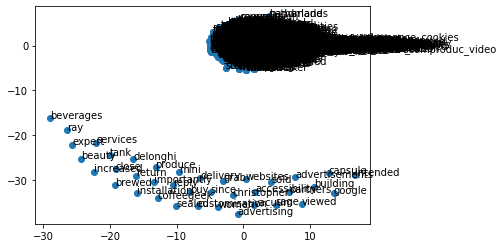

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])

for word, pos in df.iterrows():
    ax.annotate(word, pos)

plt.show()

In [ ]:
# https://stackoverflow.com/questions/56076714/gensim-plot-list-of-words-from-a-word2vec-model
def display_wordlist(model, wordlist):
    vectors = [model[word] for word in wordlist if word in model.wv.vocab.keys()]
    word_labels = [word for word in wordlist if word in model.wv.vocab.keys()]
    word_vec_zip = zip(word_labels, vectors)

    # Convert to a dict and then to a DataFrame
    word_vec_dict = dict(word_vec_zip)
    df = pd.DataFrame.from_dict(word_vec_dict, orient='index')

    # Use tsne to reduce to 2 dimensions
    tsne = TSNE(perplexity=65,n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(df)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display plot
    plt.figure(figsize=(16, 8)) 
    plt.plot(x_coords, y_coords, 'ro')

    for label, x, y in zip(df.index, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points')
        
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


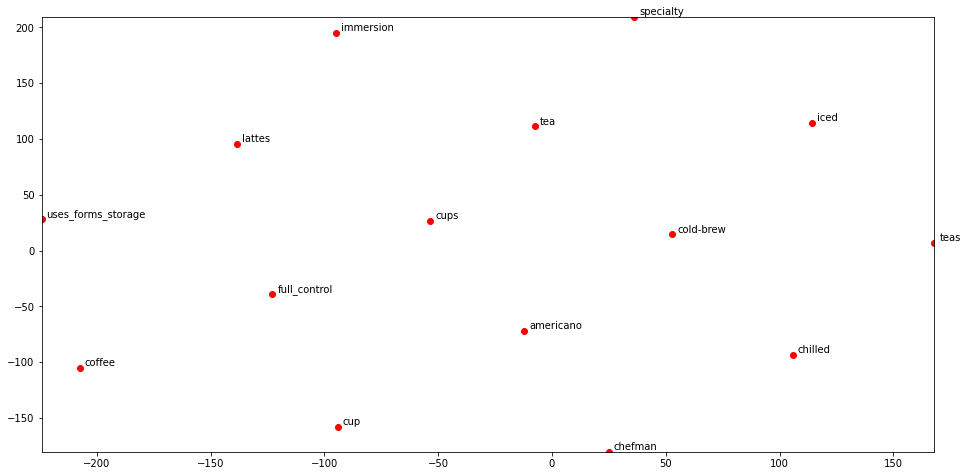

In [ ]:
words = [word[0] for word in w2v_model.wv.most_similar('cold', topn=15)]
display_wordlist(w2v_model, words)

# Save model and load with spacy

In [ ]:
model_pathname = f'{BASE_PATH}/spacy.word2vec.txt'
model_pathname_gzip = f'{BASE_PATH}/spacy.word2vec.txt.gz'
model_pathname_spacy = f'{BASE_PATH}/spacy.word2vec.model'
w2v_model.wv.save_word2vec_format(model_pathname)

In [ ]:
model_pathname

'/content/drive/MyDrive/seosecretlab/coffee machine/spacy.word2vec.txt'

In [ ]:
!gzip "$model_pathname"

In [ ]:
!python3 -m spacy init-model en "$model_pathname_spacy" --vectors-loc "$model_pathname_gzip"

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
✔ Successfully created model
4705it [00:00, 8744.55it/s]
✔ Loaded vectors from /content/drive/MyDrive/seosecretlab/coffee
machine/spacy.word2vec.txt.gz
✔ Sucessfully compiled vocab
5162 entries, 4705 vectors


# Plot with Spacy

In [ ]:
nlp = spacy.load(model_pathname_spacy)

In [ ]:
spacy_word1 = nlp.vocab['coffee']
spacy_word2 = nlp.vocab['brew']
spacy_word3 = nlp.vocab['cheese']
spacy_word4 = nlp.vocab['cold']
spacy_word5 = nlp.vocab['cold-brew']

In [ ]:
spacy_word1.similarity(spacy_word1)

1.0

In [ ]:
spacy_word1.similarity(spacy_word2)

0.45522588

In [ ]:
spacy_word1.similarity(spacy_word3)

-0.13083689

In [ ]:
def most_similar_spacy(word, topn=10):
    allwords = [w for w in nlp.vocab if w.has_vector and w.is_lower and w.lower_ != word.lower_]
    by_similarity = sorted(allwords, key=lambda w: word.similarity(w), reverse=True)
    return by_similarity[:topn]

In [ ]:
[w.text for w in most_similar_spacy(spacy_word1)]

['espresso',
 'brew',
 'from',
 'cup',
 'which',
 'so',
 'machine',
 'best',
 'its',
 'make']

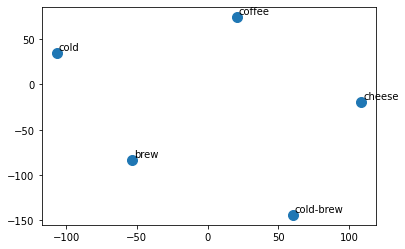

In [ ]:
tsne_model = TSNE(n_components=2)
data = np.array([spacy_word1.vector, spacy_word2.vector, spacy_word3.vector, spacy_word4.vector, spacy_word5.vector])
data_2d = tsne_model.fit_transform(data)

labels = ['coffee', 'brew', 'cheese', 'cold', 'cold-brew']

plt.scatter(data_2d[:, 0], data_2d[:, 1], s=100)

for i, txt in enumerate(labels):
    plt.annotate(txt, (data_2d[i,0], data_2d[i,1]), xytext=(2, 3), textcoords='offset points')

plt.show()

# Build a list of popular words

In [ ]:
popular = most_frequent_words(trigram_model, sentences, 25, 1, 3)
popular[:10]

['coffee',
 'machine',
 'best',
 'coffee_maker',
 'machines',
 'brew',
 'espresso',
 'make',
 'so',
 'cup']

In [ ]:
unpopular = less_frequent_words(trigram_model, sentences, 25, 1, 3)
unpopular[:10]

['sought',
 'narrowing',
 'cliff',
 'best-pick',
 'brain-child',
 'salesman',
 'harry',
 'norville',
 'sydney',
 'radios']

# Calculate word counts (first keyword only)

In [ ]:
def count_in_content(word, content):
    return sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word.replace('_', ' ')), content))

In [ ]:
current = results[0]
current_keyword = current[0]['keyword']
current_keyword

'coffee machine recommendations'

In [ ]:
current_keyword_urls = []

for serp in current:
    if serp['type'] == 'organic':
        current_keyword_urls.append(serp['url'])    

In [ ]:
counts_by_url = dict()

for serp in processed_serps:    
    counts_by_url[serp['url']] = dict()
    for word in all_words:
        counts_by_url[serp['url']][word] = count_in_content(word, serp['text'])

In [ ]:
counts_by_url[processed_serps[0]['url']][all_words[0]]

125

# Correlation per popular word  (first keyword only)

In [ ]:
def show_plot(w, kw, i, axs, xlim=None, max_pos=100):
    corr_range = [x+1 for x in list(range(0, len(current_keyword_urls)))]

    corr_counts = []
    for url in current_keyword_urls:
        corr_counts.append(counts_by_url[url][w])
    
    x = pd.Series(corr_range)
    y = pd.Series(corr_counts)
    xy = np.array([x, y])    

    slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)

    axs[i].plot(x, y, linewidth=0, marker='s', label=w)
    axs[i].plot(x, intercept + slope * x)
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
    axs[i].set_title(f'{w} ({max_pos})')
    
    if xlim:
        axs[i].set_xlim(xlim)
    
    axs[i].legend(facecolor='white')    

In [ ]:
def plot_words_corr(words, max_pos):
    fig, axs = plt.subplots(len(words), figsize=(4, 10))
    fig.tight_layout()

    for i, w in enumerate(words):
        show_plot(w, current_keyword, i, axs, [0, max_pos], max_pos)

    for ax in axs.flat:
        ax.set(xlabel='position', ylabel='count')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.show()

In [ ]:
_words = popular[:6] # most popular
_words

['coffee', 'machine', 'best', 'coffee_maker', 'machines', 'brew']

In [ ]:
words = []
min_count = 50

for _word in _words:
    word_counts = []

    for url in current_keyword_urls:
        word_counts.append(counts_by_url[url][_word])
    
    if sum(word_counts) >= min_count and _word in vocab and _word not in STOP_WORDS:
        words.append(_word)

words

['coffee', 'machine', 'best', 'coffee_maker', 'machines', 'brew']

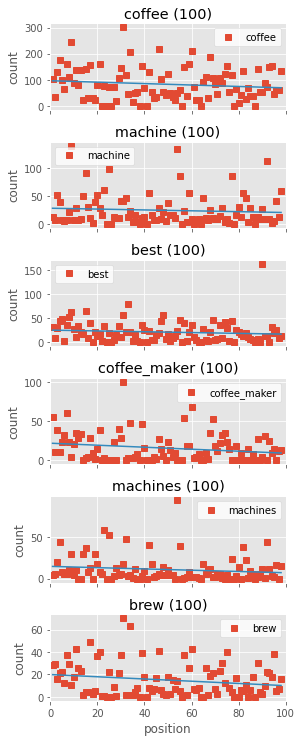

In [ ]:
plot_words_corr(words, 100)

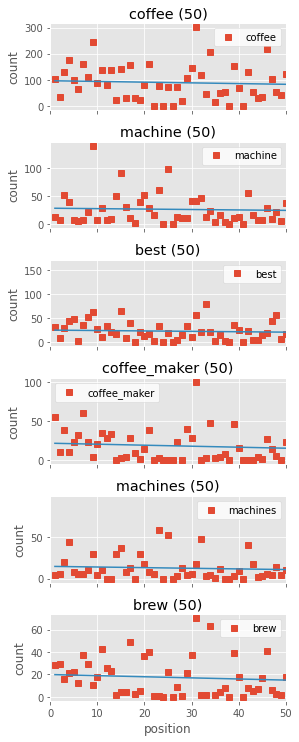

In [ ]:
plot_words_corr(words, 50)

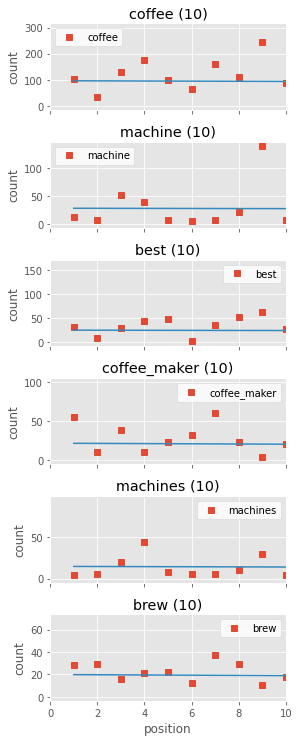

In [ ]:
plot_words_corr(words, 10)